In [1]:
import sys
import os
import os.path as op

import numpy as np
import pandas as pd
import datetime
import netCDF4 as netcdf
from datetime import timedelta
from math import pi
import xarray as xr
import glob

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..'))

# dependencies
from lib import wrapSpectra, spectra, sat, plot_sat, model
from lib.config import * 


# From energy bins: Calculate Hs, T, C, Ttime

In [2]:
ds = xr.open_dataset(op.join(p_output, 'energy_BINS.nc'))
ds_data = xr.open_dataset(op.join(p_output, 'ds_dataTracks.nc'))

In [3]:
g = 9.806
rad_ang = 15*(2*pi)/360
dk = np.diff(np.append(0, ds.k))

dataset = xr.Dataset()
for pfile, file in enumerate(ds.file):
    sys.stdout.write('\r File number: {0}\{1}'.format(pfile,len(ds_data.file.values)))
    sys.stdout.flush()
    
    dsi = ds.isel(file=pfile).load()
    
    # wavelength, period, celerity
    wl = 2*np.pi/dsi.k
    T = np.sqrt(2*np.pi*wl/g)
    C = g*T/(2*np.pi)
    Cg = 0.5 * C
    
    # Disipation term - Air Sea Viscosity
    dens_rate = 0.0013
    va = 1.4 * 10**(-5)
    nu = 2*dens_rate*(1/(g*Cg))*((2*np.pi/T)**(5/2))*np.sqrt(2*va)
            
    Ttime = (dsi.distance/Cg)
    
    H = 4*np.sqrt(((dsi.slopeD/dsi.k)*rad_ang)*(dk))
    dsi = dsi.assign(H_sinNu=H, H=xr.where(H - nu*dsi.distance < 0, 0, H - nu*dsi.distance),
                     nu=nu, distance=dsi.distance, T=T, Ttime=Ttime)

    dsi = dsi.drop(['longitude', 'latitude', 'bearing1']).expand_dims('file')
    dataset = xr.merge([dataset, dsi])

 File number: 100\151

In [4]:
dataset.to_netcdf(op.join(p_output, 'params_BINS.nc'))

In [4]:
dataset = xr.open_dataset(op.join(p_output, 'params_BINS.nc'))

In [6]:
dataset

<xarray.Dataset>
Dimensions:        (file: 101, k: 32, nbox: 492, partition: 3, posneg: 2, theta: 72)
Coordinates:
  * file           (file) object 'CFO_OP05_SWI_L2_____F_20210213T004756_20210...
  * nbox           (nbox) int64 14 15 16 17 18 19 20 ... 500 501 502 503 504 505
  * theta          (theta) int64 0 5 10 15 20 25 30 ... 330 335 340 345 350 355
  * partition      (partition) int64 1 2 3
  * posneg         (posneg) int64 0 1
  * k              (k) float32 0.01257 0.01389 0.01535 ... 0.2284 0.2524 0.2789
Data variables:
    time           (file, nbox, posneg, theta) datetime64[ns] ...
    distance       (file, nbox, posneg) float64 ...
    pos_corr       (file, nbox, posneg, partition) float64 ...
    mf_hs          (file, posneg, nbox) float64 ...
    mf_tp          (file, posneg, nbox) float64 ...
    mf_hs0         (file, posneg, nbox) float64 ...
    mf_md0         (file, posneg, nbox) float64 ...
    mf_mp0         (file, posneg, nbox) float64 ...
    mf_hs1         (file, posneg, nbox) float64 ...
    mf_md1         (file, posneg, nbox) float64 ...
    mf_mp1         (file, posneg, nbox) float64 ...
    mf_hs2         (file, posneg, nbox) float64 ...
    mf_md2         (file, posneg, nbox) float64 ...
    mf_mp2         (file, posneg, nbox) float64 ...
    slopeD         (file, nbox, posneg, theta, k) float64 ...
    SWH(m)         (file, posneg, nbox, partition) float64 ...
    wavelength(m)  (file, posneg, nbox, partition) float64 ...
    direction (°)  (file, posneg, nbox, partition) float32 ...
    H_sinNu        (file, nbox, posneg, theta, k) float64 ...
    H              (file, nbox, posneg, theta, k) float64 ...
    nu             (file, k) float32 ...
    T              (file, k) float32 ...
    Ttime          (file, nbox, posneg, k) float64 ...

In [7]:
sys.exit()

SystemExit: 

In [ ]:
# swell spatial decay rate m.

In [5]:
#dft = dsi[['H', 'H_sinNu', 'nu', 'distance']].to_dataframe().dropna()
dft = dataset[['H', 'H_sinNu', 'nu', 'distance']].to_dataframe().dropna()

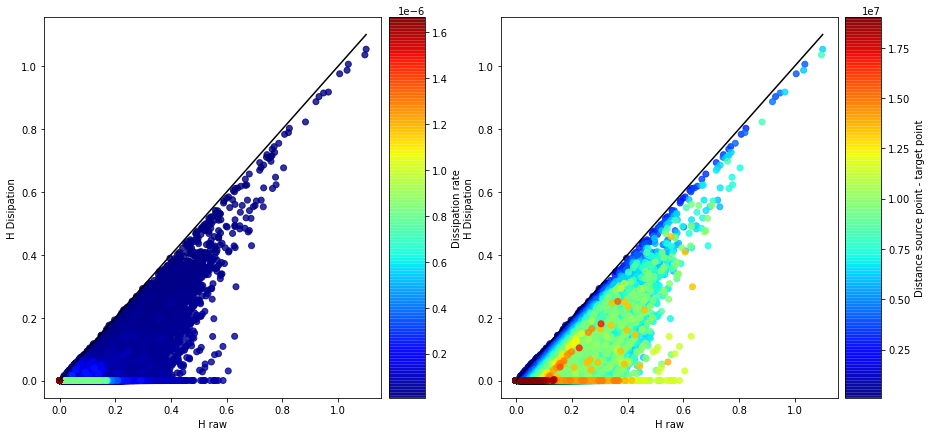

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15,7))

# axis 0
im = axs[0].scatter(dft.H_sinNu[np.argsort(dft.nu)], dft.H[np.argsort(dft.nu)], c=dft.nu[np.argsort(dft.nu)], 
                    cmap='jet', alpha=0.8)
axs[0].plot([0, np.nanmax(dft.H_sinNu)], [0, np.nanmax(dft.H_sinNu)], c='k')
axs[0].set_xlabel('H raw')
axs[0].set_ylabel('H Disipation')

axc, loc = plot_sat.add_colorbar(axs[0])
fig.add_axes(axc)
plt.colorbar(im, cax=axc, label='Dissipation rate')

# axis 1
im1 = axs[1].scatter(dft.H_sinNu[np.argsort(dft.distance)], dft.H[np.argsort(dft.distance)], c=dft.distance[np.argsort(dft.distance)], 
                     cmap='jet', alpha=0.8)
axs[1].plot([0, np.nanmax(dft.H_sinNu)], [0, np.nanmax(dft.H_sinNu)], c='k')
axs[1].set_xlabel('H raw')
axs[1].set_ylabel('H Disipation')

axt, loc = plot_sat.add_colorbar(axs[1])
fig.add_axes(axt)
plt.colorbar(im1, cax=axt, label='Distance source point - target point')

plt.show()

In [ ]:
dft.nu[np.argsort(dft.nu)].min()